In [1]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import math
import scipy.io
from IPython.display import Image
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
plt.rcParams.update({'font.size': 14})

### Functions and such.

In [2]:
def kernel(X1, X2, delta_sq = 50.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d)
        X2: Array of n points (n x d)

    Returns:
        Covariance matrix (m x n)
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-1.0 / delta_sq * sqdist)

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

### Initialize stuff.

In [12]:
#Number of tasks
m = 4
#Number of initial points for each task
n_init_per_task = 10
#Number of testing points to consider
n_test = 5040
#Total number of distinct points in training
n = n_init_per_task * m
#Target number of points
n_target = 50 * m

rmse_dict = {}

#Hyperparameters
pi = 1e-04
tau = 1
delta_sq = 100

#s is inputs, eta is outputs
#Each key in the dictionary will be values for a task
#For eg, s[2] will have training points from task 2.
s, s_test, eta, eta_test, eta_predicted = {}, {}, {}, {}, {}

#Initialize
for i in range(1, m + 1):
    df = pd.read_csv('EngineDatasetShrinkedCSV/part_'+str(i)+'_5.csv')

    training_points = np.sort(np.random.randint(0, len(df), n_init_per_task))

    s[i] = df.iloc[training_points].values[:,:-1]
    eta[i] = df.iloc[training_points].values[:,-1]

    df = df.drop(training_points, axis = 0)

    testing_points = np.sort(np.random.randint(0, len(df), n_test))

    s_test[i] = df.iloc[testing_points].values[:,:-1]
    eta_test[i] = df.iloc[testing_points].values[:,-1]

### Multi-task Masheen Larning.

In [13]:
#Continue sampling till target number of points reached
while n <= n_target:
    #Calculate and subtract the observed value means from each task.
    means = []
    means = [eta[i].mean() for i in range(1, m + 1)]
    for i in range(1, m + 1):
        eta[i] -= means[i - 1]
    
    #Append all training points together (for future ease)
    all_n_training_points = s[1]
    for i in range(2, m + 1):
        all_n_training_points = np.append(all_n_training_points, s[i], axis = 0)
    
    #Find the kernels using delta_sq previously initialized    
    K = {}
    for i in range(1, m + 1):
        K[i] = kernel(s[i], all_n_training_points, delta_sq)
    K_overall = kernel(all_n_training_points, all_n_training_points, delta_sq)
    
    #Initialize parameters for EM algorithm
    mu_alpha = np.ones(n)
    C_alpha = np.eye(n)
    sigma_sq = 1.0
    
    alpha_dict = {}
    C_alpha_dict = {}
    error = 1e04
    tol = 1e-02
    
    #EM algorithm begin
    while (error > tol):

        #E-step
        C_alpha_inverse = np.linalg.inv(C_alpha)
        for i in range(1, m + 1):
            C_alpha_dict[i] = np.linalg.inv( (1/sigma_sq)*np.dot(np.transpose(K[i]), K[i]) + C_alpha_inverse )    
            alpha_dict[i] = np.dot( C_alpha_dict[i] , (1/sigma_sq)*np.dot(np.transpose(K[i]), eta[i]) + np.dot(C_alpha_inverse,mu_alpha) )

        #M-Step
        musum = np.zeros(n)
        for i in range(1, m + 1):
            musum += alpha_dict[i]  
        mu_alpha = 1/(pi + m) * musum

        calphasum = np.zeros((n,n))
        diffsum = np.zeros((n,n))
        for i in range(1, m + 1):
            calphasum += C_alpha_dict[i]
            temp = alpha_dict[i] - mu_alpha
            diffsum += np.dot( temp , np.transpose(temp) )
        C_alpha = 1/(tau + m) * ( pi*np.dot(mu_alpha, np.transpose(mu_alpha)) + tau*np.linalg.inv(K_overall) + \
                                calphasum + diffsum)

        sigma_sq_previous = sigma_sq
        finalsum = 0
        for i in range(1, m + 1):
            finalsum += np.linalg.norm(eta[i] - np.dot(K[i], alpha_dict[i]))**2 + \
                        np.trace(np.dot(K[i] , np.dot(C_alpha_dict[i], np.transpose(K[i]))))
        sigma_sq = 1/n * finalsum
        error = abs(sigma_sq - sigma_sq_previous)
    #EM algorithm end
    
    #Find RMSE for each task
    rmse = []
    for i in range(1, m + 1):
        eta_predicted[i] = np.dot(np.transpose(alpha_dict[i]) , kernel(all_n_training_points, s_test[i], delta_sq))
        #Add means to each prediction
        eta_predicted[i] += means[i - 1]
        #Calculate RMSE for each task
        rmse.append(np.sqrt( ((eta_predicted[i] - eta_test[i])**2).sum() /len(s_test[i])))
    print(np.round(rmse,3))
    
    #Add means back to the training data, to prep for next iteration
    for i in range(1, m + 1):
        eta[i] += means[i - 1]
    
    
    #Find the variance for each task
    kinvtest = np.linalg.inv(K_overall + sigma_sq*np.eye(n))
    variance_dict = {}
    for i in range(1, m+1):
        kstarforstest1 = kernel(all_n_training_points, s_test[i], delta_sq)
        kstarstar = kernel(s_test[i] , s_test[i], delta_sq)
        variance = np.diagonal(kstarstar - kstarforstest1.T.dot(kinvtest.dot(kstarforstest1)))
        variance_dict[i] = variance
    
    #Find the maximum variance variance point and its task
    var_max, idx_max = [] , []
    for arr in variance_dict.values():
        var_max.append(np.max(arr))
        idx_max.append(np.argmax(arr))
    task_id, point_id = np.argmax(var_max)+1 , idx_max[np.argmax(var_max)]
    
    #Insert the point into training set
    s[task_id] = np.append(s[task_id], s_test[task_id][point_id].reshape(1,-1), axis = 0)
    eta[task_id] = np.append(eta[task_id], eta_test[task_id][point_id])
    
    #Remove the point from testing set
    s_test[task_id] = np.delete(s_test[task_id] , point_id, 0)
    eta_test[task_id] = np.delete(eta_test[task_id] , point_id)
    eta_predicted[task_id] = np.delete(eta_predicted[task_id], point_id)
    variance_dict[task_id] = np.delete(variance_dict[task_id] , point_id)
    
    #Update n
    n+=1

[6.618 4.762 5.213 3.872]
[6.607 4.756 5.168 3.865]
[6.596 4.742 4.963 3.854]
[6.596 4.749 4.964 3.855]
[6.323 4.746 4.955 3.874]
[6.335 4.756 5.02  3.891]
[6.291 4.729 4.891 3.856]
[6.289 4.769 4.889 3.855]
[6.263 4.739 4.849 4.065]
[6.222 4.667 4.695 3.992]
[5.85  4.588 4.644 3.899]
[5.799 4.584 4.646 3.883]
[5.892 4.55  4.626 3.883]
[5.878 4.458 4.609 3.858]
[5.878 4.458 4.614 3.859]
[5.877 4.457 4.615 3.799]
[5.885 4.49  4.622 3.804]
[5.859 4.572 4.586 3.806]
[5.86  4.572 4.585 3.77 ]
[5.856 4.524 4.579 3.767]
[5.857 4.511 4.58  3.766]
[5.852 4.508 4.577 3.858]
[5.833 4.444 4.556 3.839]
[5.895 4.443 4.556 3.838]
[5.894 4.442 4.555 3.817]
[5.954 4.423 4.542 3.796]
[5.934 4.439 4.518 3.767]
[5.999 4.434 4.507 3.766]
[5.966 4.432 4.504 3.767]
[5.966 4.44  4.505 3.765]
[5.973 4.438 4.503 3.764]
[5.98  4.462 4.507 3.772]
[5.973 4.414 4.496 3.776]
[5.97  4.41  4.486 3.725]
[5.85  4.383 4.46  3.703]
[5.849 4.361 4.443 3.858]
[5.67  4.303 4.392 3.815]
[5.669 4.304 4.401 3.816]
[5.646 4.278

### Plot stuff.

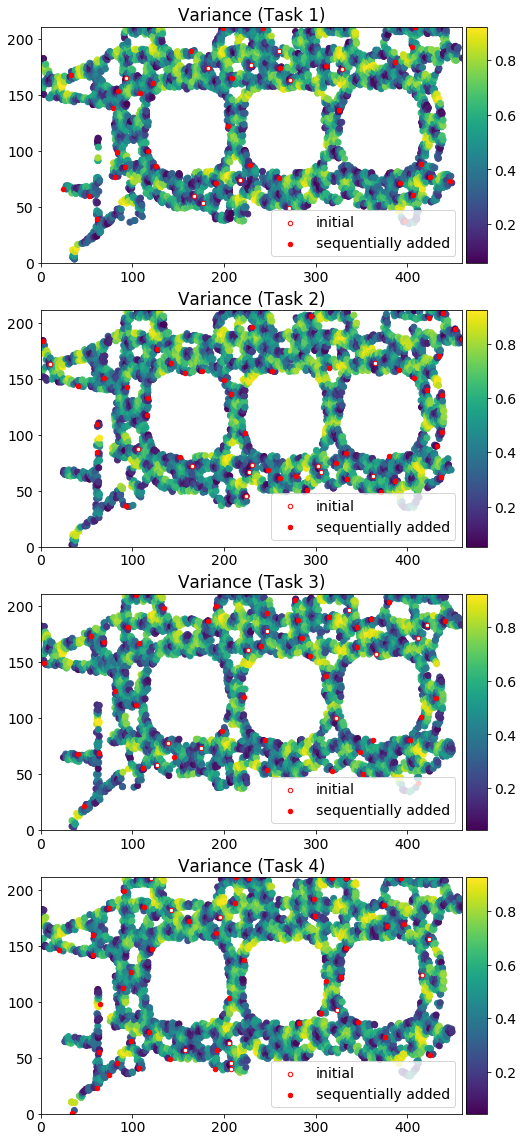

In [19]:
f, axarr = plt.subplots(m, 1, figsize = (8,m*5))

for i in range(1, m+1):    
    ax = axarr[i-1]
    z = ax.scatter(s_test[i][:,0], s_test[i][:,1], c = variance_dict[i])
    add_colorbar(z)
    ax.scatter(s[i][:n_init_per_task,0], s[i][:n_init_per_task,1], facecolors='white', edgecolors='red', s = 20, label = 'initial')
    ax.scatter(s[i][n_init_per_task:,0], s[i][n_init_per_task:,1], color = 'red', s = 20, label = 'sequentially added')
    ax.set_xlim([0, df.X.max()])
    ax.set_ylim([0, df.Y.max()])
    ax.set_title('Variance (Task '+str(i)+')')
    ax.legend()
#plt.savefig('4tl_sampling_variance.jpg', dpi = 400, bbox_inches = 'tight')
plt.show()

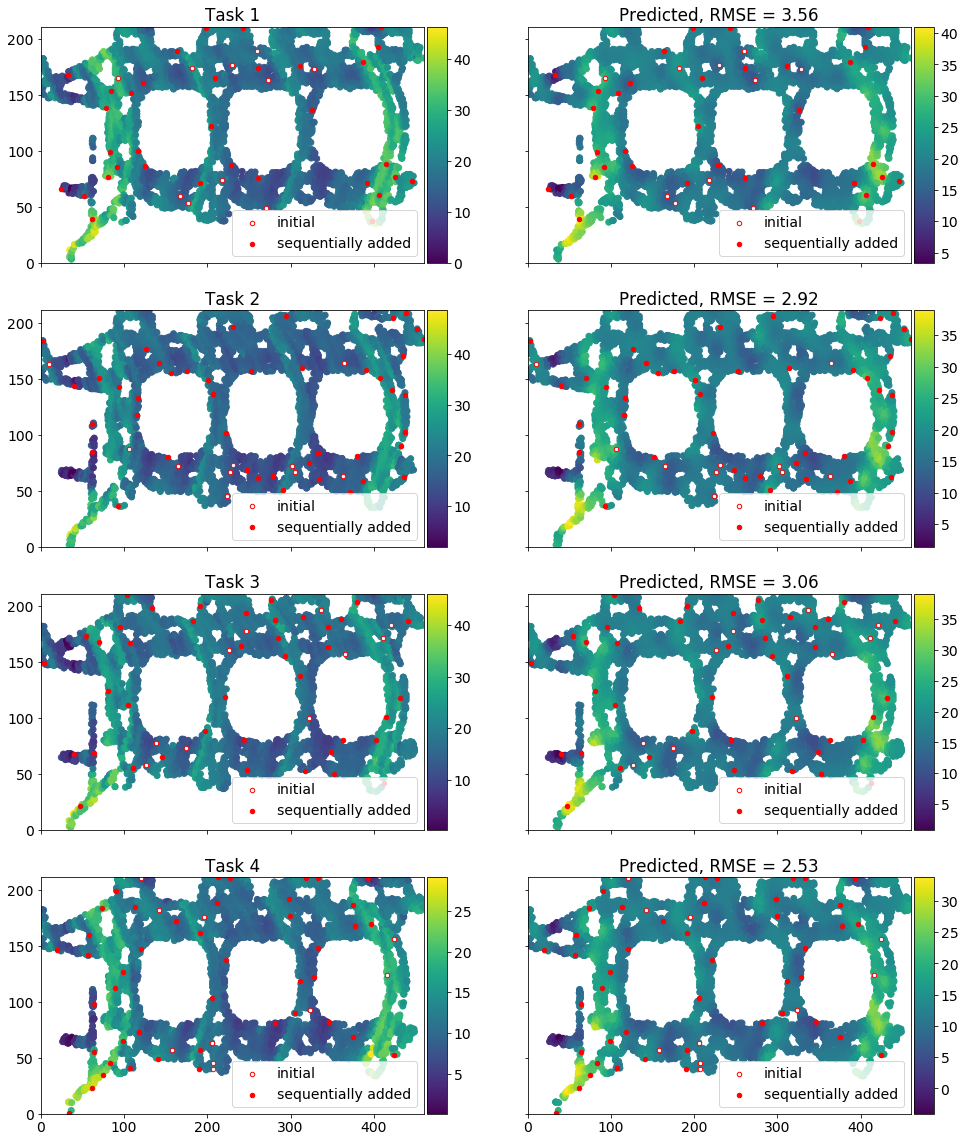

In [18]:
f, axarr = plt.subplots(m, 2, figsize = (16, 5*m), sharex = True, sharey = True)
for i in range(1, m+1):
    ax1, ax2 = axarr[i-1, 0], axarr[i-1, 1]

    z1 = ax1.scatter(s_test[i][:,0], s_test[i][:,1], c = eta_test[i])
    add_colorbar(z1)
    ax1.scatter(s[i][:n_init_per_task,0], s[i][:n_init_per_task,1], facecolors='white', edgecolors='red', s = 20, label = 'initial')
    ax1.scatter(s[i][n_init_per_task:,0], s[i][n_init_per_task:,1], color = 'red', s = 20, label = 'sequentially added')
    ax1.set_xlim([0, df.X.max()])
    ax1.set_ylim([0, df.Y.max()])
    ax1.set_title('Task '+str(i))
    ax1.legend()

    z2 = ax2.scatter(s_test[i][:,0], s_test[i][:,1], c = eta_predicted[i])
    add_colorbar(z2)
    ax2.scatter(s[i][:n_init_per_task,0], s[i][:n_init_per_task,1], facecolors='white', edgecolors='red', s = 20, label = 'initial')
    ax2.scatter(s[i][n_init_per_task:,0], s[i][n_init_per_task:,1], color = 'red', s = 20, label = 'sequentially added')
    ax2.set_xlim([0, df.X.max()])
    ax2.set_ylim([0, df.Y.max()])
    ax2.set_title('Predicted, RMSE = {:.2f}'.format(rmse[i-1]))
    ax2.legend()

#plt.savefig('4tl_sampling_rmse.jpg', dpi = 400, bbox_inches = 'tight')
plt.show()